# Lectura de datos y Declaración de funciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from xgboost import XGBClassifier


# Semilla para generador de numeros aleatorios
import random
random.seed(42)

# Simplifica las marcas a los estados 'dormido' y 'despierto'
reducir_marca = lambda x : 0 if (x == 0) else 2

first = lambda x : x.value_counts().index[0]
last = lambda x : x.value_counts().index[-1]

    
# Lectura de los datos
valid_data = pd.read_csv('valid_data.csv')
valid_data.drop(columns=['fecha'], inplace=True)

tap_data = pd.read_csv('tap_data.csv')
daytime_data = tap_data[tap_data['hora'] >= 12]
daytime_data = daytime_data[daytime_data['hora'] <= 20]
daytime_data.drop(columns=['hora'], inplace=True)

# Datos
data = valid_data.copy()
data['marca'] = data['marca'].apply(reducir_marca)
tap_data['marca'] = tap_data['marca'].apply(reducir_marca)
daytime_data['marca'] = daytime_data['marca'].apply(reducir_marca)

In [2]:
def GetConsecutiveSample(dataX, dataX_norm, dataY, size):
    idx = random.randint(0, dataX.shape[0]-size)
    X = dataX.take(np.arange(idx, idx+size))
    X_norm = dataX_norm.take(np.arange(idx, idx+size))
    y = dataY.take(np.arange(idx, idx+size))
    return X, X_norm, y


def ApplyPCA(data):
    scaler = MinMaxScaler()
    data_norm = scaler.fit_transform(data)
    
    pca = PCA(0.99)
    pca_norm = PCA(0.99)
    return pd.DataFrame(pca.fit_transform(data)), pd.DataFrame(pca_norm.fit_transform(data_norm))

def CalculateWindowAccuracy(X, y, w_max, skf, out_rf, out_xgb):
    for i in range(-w_max, w_max+1, 1):
        if i == 0: continue

        elif i <  0:
            # windowing no funciona con ventanas de tamaño negativo, por lo que hay que 
            # ordenar descendentemente por indice los datos antes de aplicarlo
            # y volver a ordenarlo después
            roll = X.sort_index(ascending=False).rolling(window=abs(i)).apply(np.mean).dropna()
            roll.sort_index(inplace=True)
            # En ventanas hacia detras, es equivalente a coger el ultimo elemento de la ventana
            rolly = y.rolling(window=abs(i)).apply(last).dropna()

        else:
            roll = X.rolling(window=i).apply(np.mean).dropna()
            # En ventanas hacia delante, es equivalente a coger el primer elemento de la ventana
            rolly = y.rolling(window=i).apply(first).dropna()

        out_rf[i] = cross_validate(RandomForestClassifier(random_state=42), roll, rolly, cv=skf, n_jobs=-1)
        out_xgb[i] = cross_validate(XGBClassifier(random_state=42), roll, le.fit_transform(rolly), cv=skf, n_jobs=-1)

# Variables comunes
data_size = 20000
w_max = 20

skf = StratifiedKFold(n_splits=5)
le = LabelEncoder()

## Plotting

In [3]:
plt.rcParams.update({'font.size': 18})
def PlotWindowAccuracy(out_rf, out_xgb, out_name):
    plt.figure(figsize=(12,8))
    plt.ylim(0.7, 1)
    
    
    for i in out_rf.keys():
        accs = out_rf[i]['test_score']
        for y in accs:
            plt.plot(i, y, 'xr', alpha=0.5)
        
        if i == 1: plt.axhline(y=np.mean(accs), color='r', linestyle='--', alpha=0.65)
        a = plt.plot(i, np.mean(accs), 'or', label='rf')
        
    for i in out_xgb.keys():
        accs = out_xgb[i]['test_score']
        for y in accs:
            plt.plot(i, y, 'xb', alpha=0.5)
        
        if i == 1: plt.axhline(y=np.mean(accs), color='b', linestyle='--', alpha=0.65)
        b = plt.plot(i, np.mean(accs), 'ob', label='xgb')
        
    plt.legend(handles=[a[0], b[0]], loc=4)
    plt.grid(alpha=0.3)
    plt.xlabel('Tamaño de ventana')
    plt.ylabel('accuracy')
    #plt.suptitle('Evolución de la precisión según el tamaño de ventana', fontsize=20)
    plt.savefig(f'plots/{out_name}_acc.png')
    

def PlotWindowTime(out_rf, out_xgb, out_name):
    plt.figure(figsize=(12,8))
    
    for i in out_rf.keys():
        accs = out_rf[i]['fit_time']
        for y in accs:
            plt.plot(i, y, 'xr', alpha=0.5)
        
        if i == 1: plt.axhline(y=np.mean(accs), color='r', linestyle='--', alpha=0.65)
        a = plt.plot(i, np.mean(accs), 'or', label='rf')
        
    for i in out_xgb.keys():
        accs = out_xgb[i]['fit_time']
        for y in accs:
            plt.plot(i, y, 'xb', alpha=0.5)
        
        if i == 1: plt.axhline(y=np.mean(accs), color='b', linestyle='--', alpha=0.65)
        b = plt.plot(i, np.mean(accs), 'ob', label='xgb')
    plt.ylim(0, 6)
    plt.legend(handles=[a[0], b[0]])
    #plt.suptitle('Tiempos de entrenamiento', fontsize=20)
    plt.savefig(f'plots/{out_name}_time.png')

# Caso 1: datos en bruto

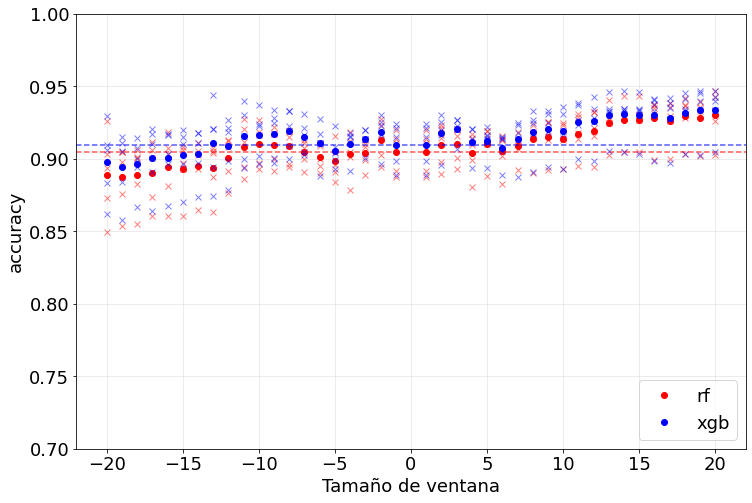

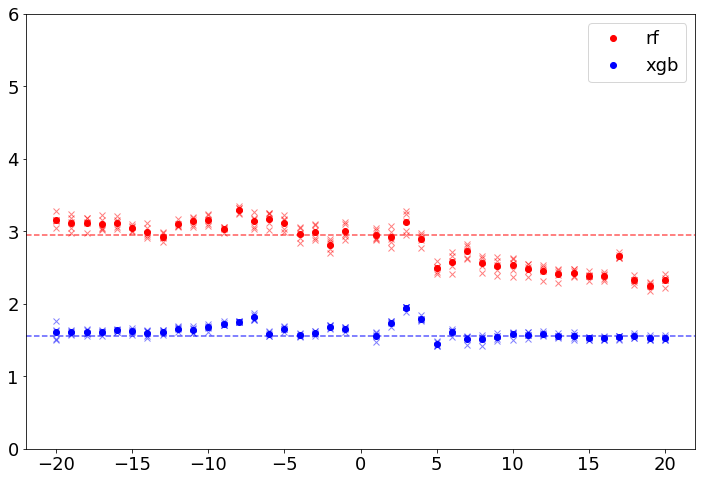

In [4]:
pca_data, pca_data_norm = ApplyPCA(data.drop(columns=['marca']))
X, X_norm, y = GetConsecutiveSample(pca_data, pca_data_norm, data['marca'], data_size)

out_rf = {}
out_xgb = {}


CalculateWindowAccuracy(X, y, w_max, skf, out_rf, out_xgb)
PlotWindowAccuracy(out_rf, out_xgb, 'normal')
PlotWindowTime(out_rf, out_xgb, 'normal')

## PCA con Escalado

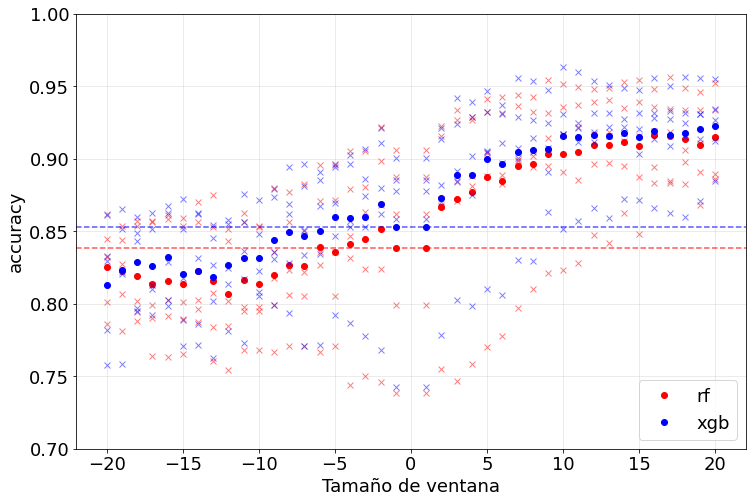

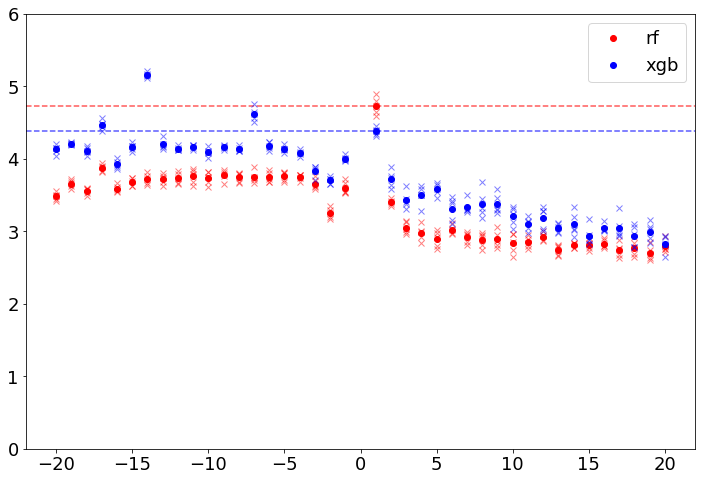

In [5]:
out_rf_norm = {}
out_xgb_norm = {}

CalculateWindowAccuracy(X_norm, y, w_max, skf, out_rf_norm, out_xgb_norm)
PlotWindowAccuracy(out_rf_norm, out_xgb_norm, 'normal_norm')
PlotWindowTime(out_rf_norm, out_xgb_norm, 'normal_norm')

# Caso 2: Datos TAP

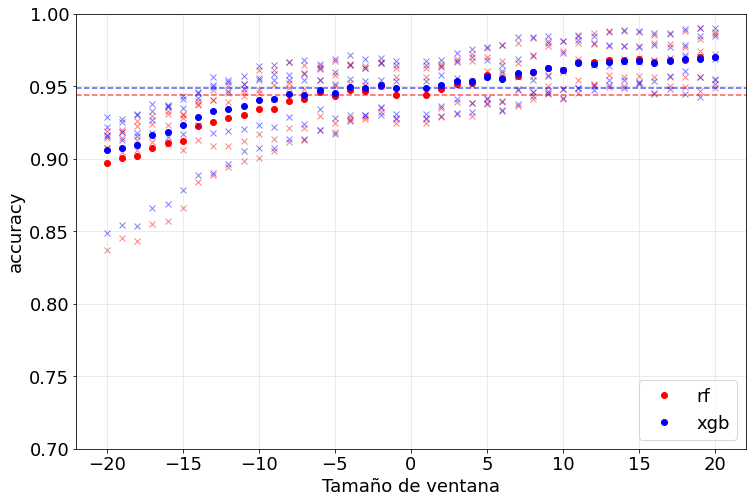

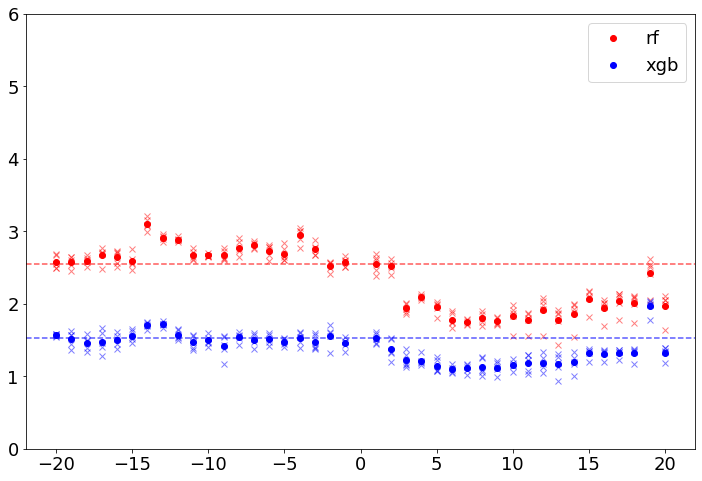

In [6]:
pca_tap, pca_tap_norm = ApplyPCA(tap_data.drop(columns=['marca']))
X, X_norm, y = GetConsecutiveSample(pca_tap, pca_tap_norm, tap_data['marca'], data_size)

out_rf_tap = {}
out_xgb_tap = {}


CalculateWindowAccuracy(X, y, w_max, skf, out_rf_tap, out_xgb_tap)
PlotWindowAccuracy(out_rf_tap, out_xgb_tap, 'tap')
PlotWindowTime(out_rf_tap, out_xgb_tap, 'tap')

## PCA con Escalado

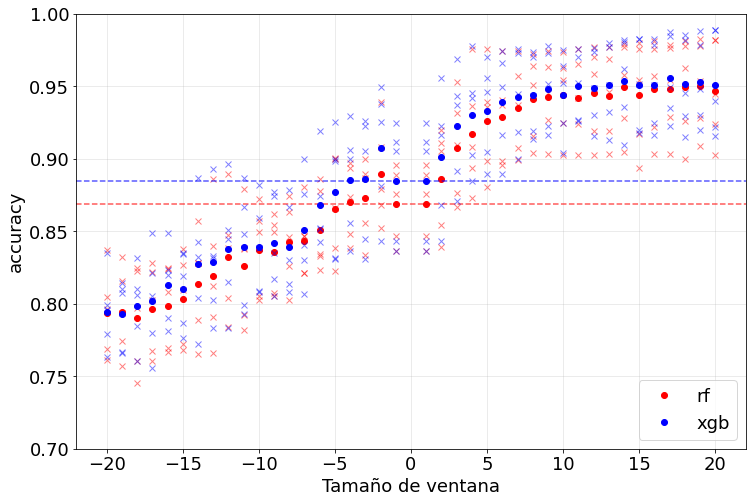

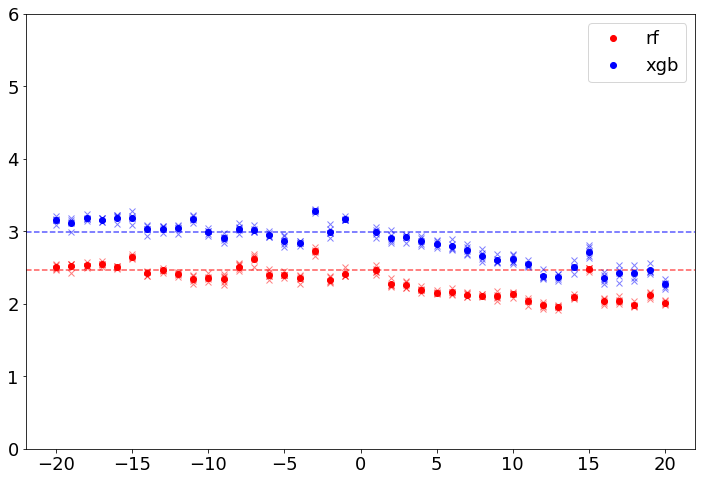

In [7]:
out_rf_tap_norm = {}
out_xgb_tap_norm = {}


CalculateWindowAccuracy(X_norm, y, w_max, skf, out_rf_tap_norm, out_xgb_tap_norm)
PlotWindowAccuracy(out_rf_tap_norm, out_xgb_tap_norm, 'tap_norm')
PlotWindowTime(out_rf_tap_norm, out_xgb_tap_norm, 'tap_norm')

# Caso 3: Datos *sin* hora

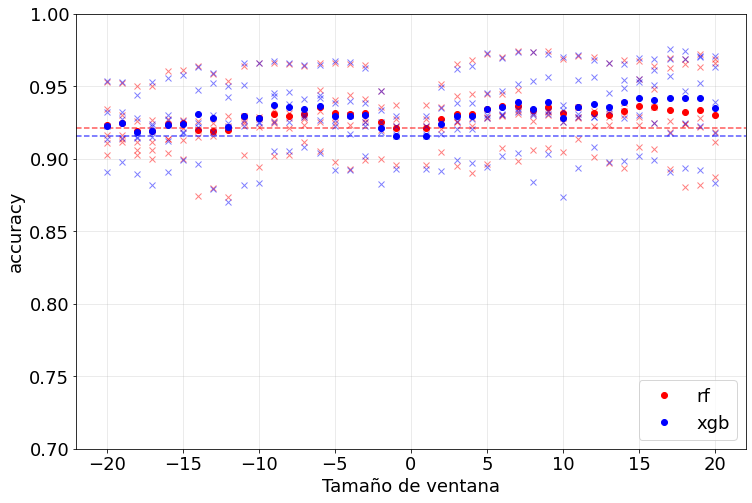

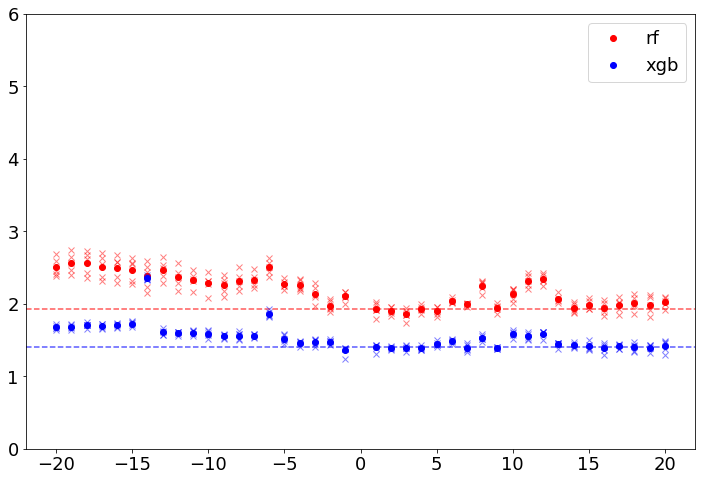

In [8]:
pca_day, pca_day_norm = ApplyPCA(daytime_data.drop(columns=['marca']))
X, X_norm, y = GetConsecutiveSample(pca_day, pca_data_norm, daytime_data['marca'], data_size)

out_rf_day = {}
out_xgb_day = {}


CalculateWindowAccuracy(X, y, w_max, skf, out_rf_day, out_xgb_day)
PlotWindowAccuracy(out_rf_day, out_xgb_day, 'day')
PlotWindowTime(out_rf_day, out_xgb_day, 'day')

## PCA con Escalado

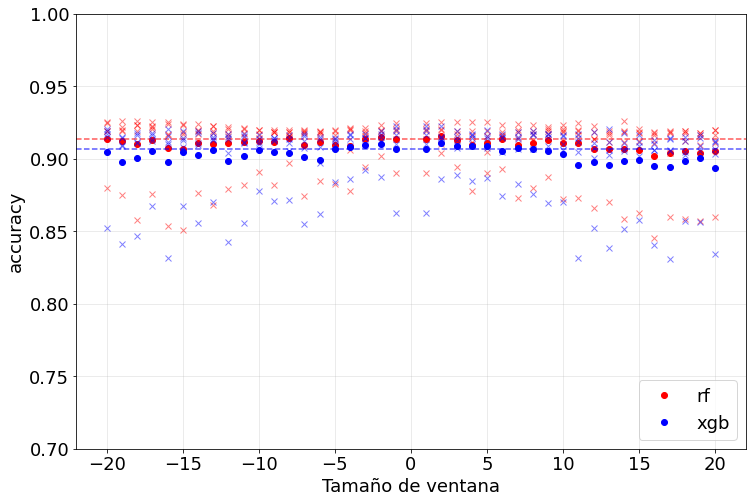

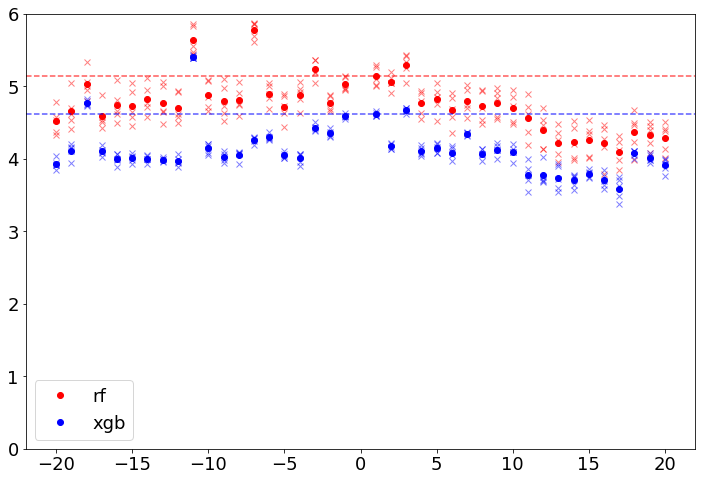

In [9]:
out_rf_day_norm = {}
out_xgb_day_norm = {}


CalculateWindowAccuracy(X_norm, y, w_max, skf, out_rf_day_norm, out_xgb_day_norm)
PlotWindowAccuracy(out_rf_day_norm, out_xgb_day_norm, 'day_norm')
PlotWindowTime(out_rf_day_norm, out_xgb_day_norm, 'day_norm')